In [1]:
import pandas as pd 
import nltk
from snorkel.labeling import PandasLFApplier, labeling_function, LFAnalysis
from snorkel.labeling.model import MajorityLabelVoter, LabelModel
from snorkel.labeling import filter_unlabeled_dataframe
from snorkel.utils import probs_to_preds
import numpy as np
import matplotlib.pyplot as plt 
from labeling_funcs.bbc_lfs import * 
from run_lgreg_utils import *
from plotting_funcs import plot_label_frequency, plot_probabilities_histogram
from mlflow import log_metric, log_param, log_artifacts
import mlflow
from datetime import datetime
import os 
from sklearn.metrics import precision_recall_fscore_support
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.linear_model import LogisticRegressionCV
from run_lgreg_utils import read_data_from_config
from lgreg_config import bbc_config as config
import warnings
warnings.filterwarnings(action='ignore')
pd.options.display.max_colwidth = 200

In [2]:
POLITICS = 4
ENTERTAINMENT = 3
SPORT = 2
BUSINESS = 1
TECH = 0
ABSTAIN = -1

kmeans = joblib.load('bbc_kmeans.joblib')
vectorizer = joblib.load('tfidf.joblib')

bbc_stop_words = ['said', 'people', 'new', 'mr']
custom_stop_words = text.ENGLISH_STOP_WORDS.union(bbc_stop_words)

In [3]:
lfs = config['lfs']

print('reading in data...')
X_train, y_train, X_dev, y_dev = read_data_from_config(config)

reading in data...


In [5]:
applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=X_train)
L_dev = applier.apply(df=X_dev)

print('fitting Label Model')
label_model = LabelModel(cardinality=config['cardinality'], verbose=True)
label_model.fit(L_train=L_train, n_epochs=500, log_freq=100, seed=123)

100%|██████████| 557/557 [00:04<00:00, 114.10it/s]


fitting Label Model


In [6]:
label_model.score(L_dev, y_dev, tie_break_policy="random")["accuracy"]

0.8132854578096947

In [8]:
probs_train = label_model.predict_proba(L=L_train)
preds_train = probs_to_preds(probs=probs_train)
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score
import seaborn as sns
print(confusion_matrix(y_train,preds_train, labels=[0, 1, 2, 3, 4]))
print(accuracy_score(y_train, preds_train))
# sns.heatmap(cm.astype(np.int32), annot=True)
print(precision_recall_fscore_support(y_train,preds_train))
probs_dev = label_model.predict_proba(L=L_dev)
preds_dev = probs_to_preds(probs=probs_dev)
print(confusion_matrix(y_dev,preds_dev, labels=[0, 1, 2, 3, 4]))
print(precision_recall_fscore_support(y_dev,preds_dev))
print(accuracy_score(y_dev, preds_dev))

[[257  24  11   1   8]
 [  9 369   0   2   2]
 [  0   1 376   0   6]
 [  7  52   2 197  31]
 [  4 125   1   0 183]]
0.8285371702637889
(array([0.92779783, 0.64623468, 0.96410256, 0.985     , 0.79565217]), array([0.8538206 , 0.96596859, 0.98172324, 0.6816609 , 0.58466454]), array([0.88927336, 0.77439664, 0.97283312, 0.80572597, 0.67403315]), array([301, 382, 383, 289, 313]))
[[ 85   4   7   1   3]
 [  3 124   1   0   0]
 [  0   0 125   1   2]
 [  1  21   0  64  11]
 [  0  49   0   0  55]]
(array([0.95505618, 0.62626263, 0.93984962, 0.96969697, 0.77464789]), array([0.85      , 0.96875   , 0.9765625 , 0.65979381, 0.52884615]), array([0.8994709 , 0.7607362 , 0.95785441, 0.78527607, 0.62857143]), array([100, 128, 128,  97, 104]))
0.8132854578096947


In [10]:
from sklearn.metrics import classification_report
target_names=['tech', 'business', 'sport', 'entertainment', 'politics']
print(classification_report(y_dev, preds_dev, target_names=target_names))

               precision    recall  f1-score   support

         tech       0.96      0.85      0.90       100
     business       0.63      0.97      0.76       128
        sport       0.94      0.98      0.96       128
entertainment       0.97      0.66      0.79        97
     politics       0.77      0.53      0.63       104

     accuracy                           0.81       557
    macro avg       0.85      0.80      0.81       557
 weighted avg       0.84      0.81      0.81       557



In [11]:
LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
lf_contains_tech_terms,0,[0],0.265588,0.265588,0.197242
lf_contains_business_terms,1,[1],0.428058,0.428058,0.329736
lf_contains_sport_terms,2,[2],0.269784,0.269784,0.151679
lf_contains_entertainment_terms,3,[3],0.129496,0.129496,0.062950
lf_contains_politics_terms,4,[4],0.293165,0.293165,0.261990
lf_kmeans_label_0,5,[2],0.238609,0.190647,0.072542
lf_kmeans_label_1,6,[0],0.166067,0.141487,0.073141
lf_kmeans_label_2,7,[3],0.118106,0.091727,0.025180
lf_kmeans_label_3,8,[1],0.366906,0.296763,0.198441
lf_kmeans_label_4,9,[4],0.110312,0.109712,0.078537


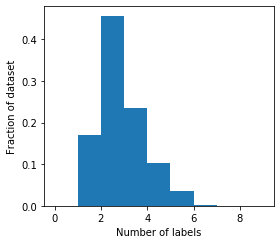

In [23]:
def plot_label_frequency(L):
    plt.figure(figsize=(4., 3.5))
    plt.hist((L != ABSTAIN).sum(axis=1), density=True, bins=range(L.shape[1]))
    plt.xlabel("Number of labels")
    plt.ylabel("Fraction of dataset")
    plt.tight_layout()
    plt.savefig(f'figures/bbc_lfs_label_freq.png', dpi=500)
    plt.show()


plot_label_frequency(L_train)

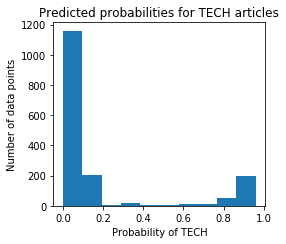

In [25]:
def plot_probabilities_histogram(label_text, savefile, Y):
    plt.figure(figsize=(4., 3.5))
    plt.hist(Y, bins=10)
    plt.xlabel(f'Probability of {label_text}')
    plt.ylabel("Number of data points")
    plt.title(f'Predicted probabilities for {label_text} articles')
    plt.tight_layout()
    plt.savefig(f'figures/{savefile}', dpi=500)
    plt.show()


probs_train = label_model.predict_proba(L=L_train)
plot_probabilities_histogram('TECH', 'bbc_pred_proba_tech.png', probs_train[:, TECH])

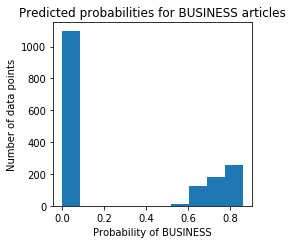

In [26]:
plot_probabilities_histogram('BUSINESS', 'bbc_pred_proba_business.png', probs_train[:, BUSINESS])

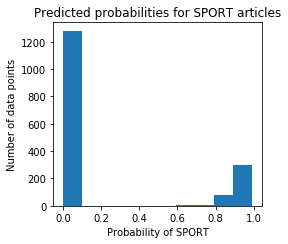

In [27]:
plot_probabilities_histogram('SPORT', 'bbc_pred_proba_sport.png', probs_train[:, SPORT])

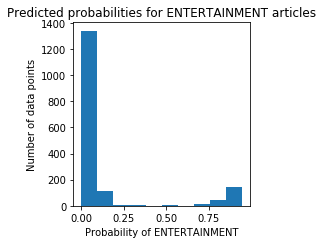

In [28]:
plot_probabilities_histogram('ENTERTAINMENT', 'bbc_pred_proba_entertainment.png', probs_train[:, ENTERTAINMENT])

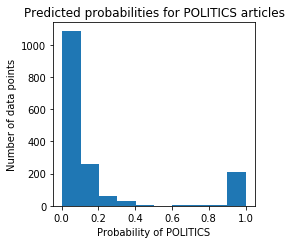

In [29]:
plot_probabilities_histogram('POLITICS', 'bbc_pred_proba_politics.png', probs_train[:, POLITICS])